In [1]:
%matplotlib inline

"""Variational auto-encoder for fashion MNIST data.
References
----------
http://edwardlib.org/tutorials/decoder
http://edwardlib.org/tutorials/inference-networks
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import os, random, sys
import tensorflow as tf

from edward.models import Bernoulli, Normal
from edward.util import Progbar
from observations import mnist
from scipy.misc import imsave

from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import ticker
import seaborn as sns
import scipy.misc
from PIL import Image, ImageOps


In [2]:
def generator(array, batch_size):
    """Generate batch with respect to array's first axis."""
    start = 0  # pointer to where we are in iteration
    while True:
        stop = start + batch_size
        diff = stop - array.shape[0]
        if diff <= 0:
            batch = array[start:stop]
            start += batch_size
        else:
            batch = np.concatenate((array[start:], array[:diff]))
            start = diff
        batch = batch.astype(np.float32) / 255.0  # normalize pixel intensities
        batch = np.random.binomial(1, batch)  # binarize images
        yield batch

In [3]:
def binarize(array, n=10):
    arr = np.zeros([n,784])
    num = np.random.randint(0, 60000, n)
    idx = 0
    for im in num:
        for pix in range(0,784):
            if array[im, pix] >= 100:
                arr[idx, pix] = 255
            else:
                arr[idx, pix] = 0
        idx += 1    
    return arr

In [4]:
ed.set_seed(42)

# DATA. MNIST batches are fed at training time.
data_dir = 'data/fashion/'
(x_train, lab_train), (x_test, lab_test) = mnist(data_dir)

# Batch size during training
M = 500
x_train_generator = generator(x_train, M)

xbin = binarize(x_train, M)
# Latent dimension
d = 2
n_epoch = 100
img_rows= 28
img_cols= 28

In [5]:
thing = binarize(x_train,100)

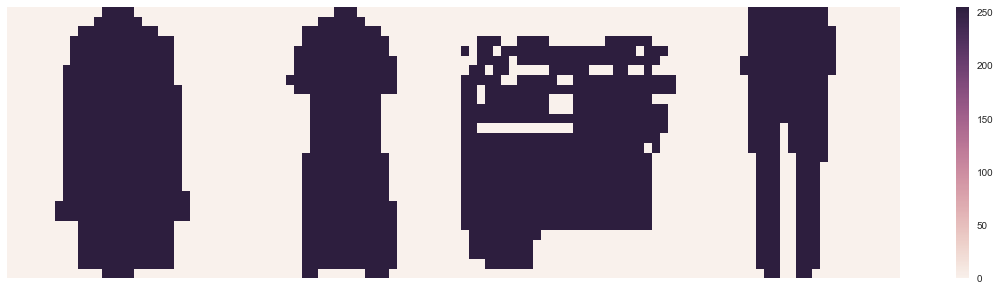

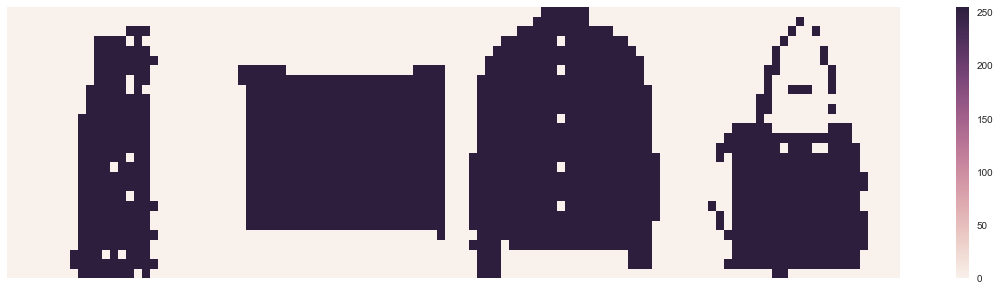

In [6]:
# function that displays heatmaps of mnist-fashion images with 4 digits per row
def show_digits(idx, row, col, img_array):
    digit1 = np.reshape(img_array[idx], (row, col))
    digit2 = np.reshape(img_array[idx+1], (row, col))
    digit3 = np.reshape(img_array[idx+2], (row, col))
    digit4 = np.reshape(img_array[idx+3], (row, col))    
    group = np.concatenate((digit1, digit2, digit3, digit4), axis=1)
    plt.figure(figsize=(20,5))
    sns.heatmap(group, linewidth=0, xticklabels=False, yticklabels=False) 

# some arbitrary images    
for idx in range(0,10,5):
    show_digits(idx, img_rows, img_cols, thing)

In [29]:
out_dir = 'log/fash_results/'

import sys
from PIL import Image

images1 = map(Image.open, ['log/fash_results/1.png', 'log/fash_results/3.png', 'log/fash_results/4.png', 
                           'log/fash_results/5.png', 'log/fash_results/7.png', 'log/fash_results/8.png',
                           'log/fash_results/9.png', 'log/fash_results/11.png', 'log/fash_results/13.png', 
                           'log/fash_results/17.png', 'log/fash_results/18.png', 'log/fash_results/20.png',
                           'log/fash_results/93.png', 'log/fash_results/94.png', 'log/fash_results/95.png', 
                           'log/fash_results/96.png', 'log/fash_results/77.png', 'log/fash_results/81.png'])

widths, heights = zip(*(i.size for i in images1))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('1', (total_width, max_height))
new_im2 = Image.new('1', (total_width, max_height))


x_offset = 0
for im in images1:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
    
    
new_im.save('log/fash_results/good_results.png')

In [32]:
out_dir = 'log/out/'


images1 = map(Image.open, ['log/out/1.png', 'log/out/3.png', 'log/out/4.png', 
                           'log/out/5.png', 'log/out/7.png', 'log/out/8.png',
                           'log/out/9.png', 'log/out/11.png','log/out/13.png', 
                           'log/out/17.png','log/out/18.png','log/out/20.png',
                           'log/out/93.png','log/out/94.png','log/out/95.png', 
                           'log/out/96.png','log/out/77.png','log/out/81.png'])

widths, heights = zip(*(i.size for i in images1))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('1', (total_width, max_height))


x_offset = 0
for im in images1:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
    
    
new_im.save('log/fash_results/mid_results.png')

In [ ]:
# MODEL
# Define a subgraph of the full model, corresponding to a minibatch of
# size M.
z = Normal(loc=tf.zeros([M, d]),
           scale=tf.ones([M, d]),
           name = 'z')

hidden = tf.layers.dense(z, 256, activation=tf.nn.relu,
                         name = 'dense')

x = Bernoulli(logits=tf.layers.dense(hidden, 28 * 28))

# INFERENCE
# Define a subgraph of the variational model, corresponding to a
# minibatch of size M.
x_ph = tf.placeholder(tf.int32, [M, 28 * 28])
hidden = tf.layers.dense(tf.cast(x_ph, tf.float32), 256,
                         activation=tf.nn.relu)
qz = Normal(loc=tf.layers.dense(hidden, d),
            scale=tf.layers.dense(
                hidden, d, activation=tf.nn.softplus),
            name='qz')

# Bind p(x, z) and q(z | x) to the same TensorFlow placeholder for x.
inference = ed.KLqp({z: qz}, data={x: x_ph})
optimizer = tf.train.RMSPropOptimizer(0.0001, epsilon=1.0)
inference.initialize(optimizer=optimizer, logdir='log/fash', n_samples=500, n_iter=2000)

tf.global_variables_initializer().run()

loss= []

n_iter_per_epoch = x_train.shape[0] // M
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0
    

    pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        pbar.update(t)
        x_batch = next(x_train_generator)
        info_dict = inference.update(feed_dict={x_ph: x_batch})
        avg_loss += info_dict['loss']
  
    # Print a lower bound to the average marginal likelihood for an
    # image.
    avg_loss /= n_iter_per_epoch
    avg_loss /= M
    print("-log p(x) <= {:0.3f}".format(avg_loss))

    loss.append(avg_loss)
    # Prior predictive check.
    
    out_dir = 'log/out/'
    images = x.eval()
    for m in range(M):
        imsave(os.path.join(out_dir, '%d.png') % m,
             images[m].reshape(28, 28))

Epoch: 1
120/120 [100%] ██████████████████████████████ Elapsed: 4797s
-log p(x) <= 482.913
Epoch: 2
120/120 [100%] ██████████████████████████████ Elapsed: 3454s
-log p(x) <= 397.377
Epoch: 3
120/120 [100%] ██████████████████████████████ Elapsed: 2983s
-log p(x) <= 358.516
Epoch: 4
120/120 [100%] ██████████████████████████████ Elapsed: 3136s
-log p(x) <= 333.281
Epoch: 5
120/120 [100%] ██████████████████████████████ Elapsed: 3104s
-log p(x) <= 316.603
Epoch: 6
120/120 [100%] ██████████████████████████████ Elapsed: 3149s
-log p(x) <= 306.874
Epoch: 7
120/120 [100%] ██████████████████████████████ Elapsed: 3088s
-log p(x) <= 301.038
Epoch: 8
120/120 [100%] ██████████████████████████████ Elapsed: 3123s
-log p(x) <= 297.149
Epoch: 9
120/120 [100%] ██████████████████████████████ Elapsed: 3218s
-log p(x) <= 294.524
Epoch: 10
120/120 [100%] ██████████████████████████████ Elapsed: 2905s
-log p(x) <= 292.545
Epoch: 11
120/120 [100%] ██████████████████████████████ Elapsed: 4246s
-log p(x) <= 291.0

In [ ]:
def mvn_plot_contours(z, label=False, ax=None):
    """Plot the contours of 2-d Normal or MultivariateNormal object.
    Scale the axes to show 3 standard deviations.
    """
    sess = ed.get_session()
    mu = sess.run(z.parameters['loc'])
    mu_x, mu_y = mu
    Sigma = sess.run(z.parameters['scale_tril'])
    sigma_x, sigma_y = np.sqrt(Sigma[0, 0]), np.sqrt(Sigma[1, 1])
    xmin, xmax = mu_x - 3 * sigma_x, mu_x + 3 * sigma_x
    ymin, ymax = mu_y - 3 * sigma_y, mu_y + 3 * sigma_y
    xs = np.linspace(xmin, xmax, num=100)
    ys = np.linspace(ymin, ymax, num=100)
    X, Y = np.meshgrid(xs, ys)
    T = tf.cast(np.c_[X.flatten(), Y.flatten()], dtype=tf.float32)
    Z = sess.run(tf.exp(z.log_prob(T))).reshape((len(xs), len(ys)))
    if ax is None:
        fig, ax = plt.subplots()
    cs = ax.contour(X, Y, Z)
    if label:
        plt.clabel(cs, inline=1, fontsize=10)

In [ ]:
sess = ed.get_session()

In [ ]:
fig, ax = plt.subplots()
trace = sess.run(qz.eval())
ax.scatter(trace[:, 0], trace[:, 1], marker=".")
mvn_plot_contours(z, ax=ax)
plt.show()

In [ ]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import os


def change_height_proportionally(img, width):
    """Change height of image proportional to given width."""
    wpercent = width / img.size[0]
    proportional_height = int(img.size[0] * wpercent)
    return img.resize((proportional_height, width), Image.ANTIALIAS)


def change_width_proportionally(img, height):
    """Change width of image proportional to given height."""
    hpercent = height / img.size[1]
    proportional_width = int(img.size[0] * hpercent)
    return img.resize((proportional_width, height), Image.ANTIALIAS)


def make_same_width(image_list):
    """Make all images in input list the same width."""
    imgs = [Image.open(i) for i in image_list]
    min_width = min([i.size[0] for i in imgs])
    resized = [change_height_proportionally(img, min_width) for img in imgs]
    return [np.asarray(i) for i in resized]


def make_same_height(image_list):
    """Make all images in input list the same height."""
    imgs = [Image.open(i) for i in image_list]
    min_height = min([i.size[1] for i in imgs])
    resized = [change_width_proportionally(img, min_height) for img in imgs]
    return [np.asarray(i) for i in resized]



Image.fromarray(np.vstack(make_same_width(
    ['A.png', 'B.png', 'E.png', 'F.png']))).save('left.png')
Image.fromarray(np.vstack(make_same_width(
    ['C.png', 'D.png']))).save('right.png')

combined = Image.fromarray(np.hstack(make_same_height(["left.png", "right.png"])))
add_text(combined)
combined.save('Combined_images.png', dpi=combined.size)
[os.remove(f) for f in ["left.png", "right.png"]]


